## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

## Check imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

You can import the autogenerated module you just created from the previous notebook.

Here we created the start of a test framework. It's a function called `test` which checks whether `a` and `b` return `True` or `False` using the comparison function `cmp`, by using `assert`.

In [2]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

Test that the variable `TEST` imported from `nb_00` equals `'test'`:

In [3]:
test_eq(TEST,'test')

In [ ]:
# To run tests in console:
# ! python run_notebook.py 01_matmul.ipynb

You'll want to be able to run tests outside of a notebook, so `run_notebook.py` can be called from the terminal and will run the notebook:

    $ python run_notebook.py 01_matmul.ipynb
    
***NOTE***: you'll have to specify your conda-environment as an ipykernel; Jupyter or nb_conda or w/e currently will not automatically detect auto-registered env kernels.

---

`fire` converts any function into a command-line interface.

## Get data

From our rules, we can use python standard library modules, fastai's datasets module, and pytorch for indexing and array creation, and also matplotlib.

In [4]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [5]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/Users/WayNoxchi/.fastai/data/mnist.pkl.gz')

In [6]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

The dataset is formatted as NumPy arrays, which aren't allowed in our foundations, so we have to convert them to tensors -- we'll use Python's `map` to map the `tensor` function over the 4 arrays to get 4 tensors.

In [7]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

testing the sizes are correct

In [8]:
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [9]:
mpl.rcParams['image.cmap'] = 'gray'

In [10]:
img = x_train[0]

In [11]:
img.view(28,28).type()

'torch.FloatTensor'

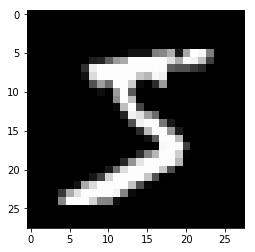

In [12]:
plt.imshow(img.view((28,28)));

There's our data. So let's start by creating a simple linear model. 

## Initial python model

For a linear model, we need something where y = ax + b. 'a' will be a bunch of weights -- a 784x10 matrix, since we have 784 pixels coming in, and 10 number classes coming out. This'll let us take in our independent variable and map it to something we can compare to our independent variable. For 'b' our bias we'll start with 10 zeros.

In [13]:
weights = torch.randn(784,10)

In [14]:
bias = torch.zeros(10)

#### Matrix multiplication

If you're going to do y = ax + b, you're going to need matrix multiplication. There are 3 loops going on in a matmul:

1. the one matrix (x) passing through the other (a)
2. all transposed-columns of (x) being applied to the current row of (a)
3. the multiple and add operations

See an example, [here](http://matrixmultiplication.xyz/).

**Also Note** this only works if n_cols of a == n_rows of b.

In [19]:
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j] # <-- the vast maj. of what deeplearning is
    return c

Time a matmul using the 1st 5 rows of the validation set:

In [20]:
m1 = x_valid[:5]
m2 = weights

In [21]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [23]:
%time t1=matmul(m1, m2)

CPU times: user 814 ms, sys: 3.73 ms, total: 818 ms
Wall time: 823 ms


As an aside, I feel like there's something very special about how you get your 10 output classes by just making sure the weight matrix you multiply by has 10 columns ... like, it really exposes how deep learning is really just matmuls.

In [24]:
t1.shape

torch.Size([5, 10])

This is kinda slow - what if we could speed it up by 50,000 times? Let's try!

In [25]:
len(x_train)

50000

The way we speed things up is by starting in the inner-most loop, and making each bit faster.

> *the way to make Python faster is to remove Python*

#### Elementwise ops

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [26]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [27]:
# elem-wise addition
a + b

tensor([12., 14.,  3.])

In [28]:
# what fraction of a is < b
(a < b).float().mean()

tensor(0.6667)

In [29]:
# can do elem-wise ops on rank-2 tensors (matrices)
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste.

---

Frob-norm: `square root of ( sum of ( matrix times itself ) )` a.k.a. Euclidean norm.

So, I think the difference between the L2 norm and Frob/Euc norm is that Frob/Euc is elem-wise and returns a single number (or maybe a rank - 2 tensor?); L2 is vector and returns a rank - 1 tensor.

[L2Norm](http://mathworld.wolfram.com/L2-Norm.html)|[FrobNorm](http://mathworld.wolfram.com/FrobeniusNorm.html)

The `i,j` in the equation above are nested for-loops.

In [30]:
(m*m).sum().sqrt()

tensor(16.8819)

This allows us to replace our innermost loop -- that loop only does an element-wise multiplication and a summation.

#### Elementwise matmul

In NumPy and PyTorch `:,` means the entirety of that axis

In [103]:
%timeit?

In [31]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum() # multip all of col j by all of row i and add
    return c

In [39]:
%timeit -n 10 _=matmul(m1, m2)

1.44 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [104]:
823 / 1.44

571.5277777777778

**Note**: Jupyter's magic `%timeit` returns *wall time* by default.

---

Check that the result is correct -- since they're floating-point numbers, check that they're close to equal:

In [46]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [47]:
test_near(t1,matmul(m1, m2))

We'll need broadcasting to get rid of the next innermost loop.

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

---

> [DL2v3@51:50](https://youtu.be/4u8FxNEDUeg?t=3110) *Broadcasting is about the most powerful tool we have for writing code in Python that runs in C-speed, or if on the GPU via PyTorch: at CUDA-speed. It allows us to get rid of nearly all our loops.*

#### Broadcasting with a scalar

In [48]:
a

tensor([10.,  6., -4.])

In [49]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [50]:
a + 1

tensor([11.,  7., -3.])

In [51]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [52]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [53]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [54]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [55]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [56]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [57]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [58]:
# this shows what c looks like when broadcast to m
t = c.expand_as(m)

In [59]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [60]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [61]:
# it's only storing 1-copy of the data
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

This shows that it knows it's a 3x3 tensor. The stride shows it knows when going column to col, it moves over by 1, but when going row to row: it stays in place (*stride 0*). This is how it's able to repeat 10,20,30 without taking extra space.

In [62]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

---

`unsqueeze` adds an additional dimension of size-1 wherever we ask for it. We can use this to broadcast columns.

In [63]:
# new-dim in axis-0 --> (1,3) rank-2 tensor
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [64]:
# new-dim in axis-1 --> (3,1) rank-2 tensor
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

In [69]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [70]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

Numpy & PyTorch allow a quick way to use `unsqueeze` via `None`-indexing. Indexing `None` is equivalent to (un?)squeezing a new axis at that index. ie: `array.unsqueeze(0)` == `array[None]`.

In [71]:
c.shape, c[None].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [72]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

You can use unsqueezing to broadcast along columns instead of rows:

In [73]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [74]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [75]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

We can now use this to get rid of our 2nd-innermost loop.

#### Matmul with broadcasting

Any time there's a trailing index colon in NumPy or PyTorch, you can optionally ommit it.

ie: `c[i,:]` == `c[i]`

In [80]:
a[...,None] * b

tensor([[ 20.,  80.,  70.],
        [ 12.,  48.,  42.],
        [ -8., -32., -28.]])

In [81]:
a[...,None]

tensor([[10.],
        [ 6.],
        [-4.]])

In [100]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i]   = (a[i  ].unsqueeze(-1) * b).sum(dim=0)
    # broadcast a over b and sum over rows
    return c

What the above broadcast just did is this:
```
a[i]: [a1, a2, a3]
b:    [b1, b2, b3]
```
`a[i].unsqueeze(-1)` # same as: `a[i,None]` or `a[...,None]`:
```
a[i] --> [ [a1],
           [a2],
           [a3] ]
```
`a[i].unsqueeze(-1) * b`:
```
[ [a1*b1, a1*b2, a1*b3],
  [a2*b1, a2*b2, a2*b3],
  [a3*b1, a3*b2, a3*b3] ]
```
`c[i] = (..).sum(dim=0)`:
```
c[i] = [(a1*b1 + a2*b1 + a3*b1), (a2*b1 + ...), (a3*b1 + ...)]
```

---


**Note** the `a` below is `a[i]`. This is because in the actual `matmul` run, we're using a matrix with 5 rows; the `a` illustrated below is just showing a single row of data.

In [89]:
a[...,None], b

(tensor([[10.],
         [ 6.],
         [-4.]]), tensor([2., 8., 7.]))

In [86]:
a[...,None]*b

tensor([[ 20.,  80.,  70.],
        [ 12.,  48.,  42.],
        [ -8., -32., -28.]])

In [93]:
(a[:,None]*b).sum(dim=0)

tensor([24., 96., 84.])

In [102]:
%timeit -n 10 _=matmul(m1, m2)

235 µs ± 37.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [105]:
823000/235

3502.127659574468

In [106]:
test_near(t1, matmul(m1, m2))

#### Broadcasting Rules

In [107]:
c[None,:]

tensor([[10., 20., 30.]])

In [108]:
c[None,:].shape

torch.Size([1, 3])

In [109]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [110]:
c[:,None].shape

torch.Size([3, 1])

In [111]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [112]:
c[None] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

In [113]:
c[None], c[:,None]

(tensor([[10., 20., 30.]]), tensor([[10.],
         [20.],
         [30.]]))

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Einstein summation [L8@1:10:45](https://youtu.be/4u8FxNEDUeg?t=4245)

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

---

Wherever a letter is repeated (i**k, k**j->ij), do a dot-product over that dimension. IOW it's like how we replaced `k` with `:` earlier (`a[i,:]` for the entire `k`-index column of `a`.). The code below will create something of size `i` by `j` by doing dot-products over the shared `k`s -- which is matmaul.

In [114]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

A batch-wise version of matmul in einsum would be: `'bik,bkj->bij'`

In [116]:
%timeit -n 10 _=matmul(m1, m2)

56.5 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
823000/56.5

14566.371681415929

In [118]:
test_near(t1, matmul(m1, m2))

### pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

In [120]:
%timeit -n 10 t2 = m1.matmul(m2)

11.8 µs ± 4.95 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
# time comparison vs pure python:
823000/11.8

69745.7627118644

In [124]:
t2 = m1@m2

In [125]:
test_near(t1, t2)

In [126]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

## Export

In [3]:
!python notebook2script.py 01_matmul-Copy1.ipynb

Converted 01_matmul-Copy1.ipynb to nb_01.py


***NOTE*** 20190322

* ~~I wasn't able to run run_notebook.py in the terminal without registering an ipykernel corresponding to my fastai env.~~

* ~~I am unable to run notebook2script.py when the kernel is set to the registered 'fastai' kernel; instead using the auto-generated [conda env:fastai] nb_conda kernel works.~~

Nevermind, looks like I forgot to set the kernel to the registered one when running `01_matmul-Copy1.ipynb`. Tests just passed.

2nd Note: the above cell fails to run when the kernel in this notebook is the registered `fastai` kernel (registered via: `(fastai) $ python -m ipykernel install --name fastai`); and succeeds when the `nb_conda` auto-gen'd kernel (`Python [conda env:fastai]`) is used.

However, while `notebook2script.py` will work for a notebook using an autogen'd kernel, `run_notebook.py` will *only* work for a notebook with a registered kernel.

This means that you can *either* run `notebook2script.py` in a notebook using the automatic kernel, *or* run it in terminal with a registered kernel.